In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from augur.utils import json_to_tree
import json
import math

In [2]:
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

# Grabbing accumulated mutations for each variant

In [3]:
# There are multiple internal nodes with value BA.2
# move this to the end of the tree/dataset
END_NODE = ["NODE_0000260"]
#END_NODE = ["NODE_0000260", "NODE_0000261", "NODE_0000265","NODE_0000267","NODE_0000271","internal_c1ab","NODE_0000284","NODE_0000285"]
# check if other internal nodes descend from 260 -- print out node path 


#grab lineage of tip node
def find_lineage(tree, child_node, rows_for_tsv):
    gene_muts = {}
    node_path = tree.get_path(child_node)
    # checking if BA.2 exists in the path
    end_node = [j for j in node_path if j.name in END_NODE]
    end_node = [0]
    if len(end_node) != 0:
        #There should never be more than 1 BA.2 node in a given path, so just grab the first element
        #end_node = end_node[0]
        # remove all elements of path before terminal node if it exists
        #node_path = node_path[node_path.index(end_node)+1:]
       # do not include child node in path
        #i = len(node_path) - 2
        i = len(node_path) - 1
        # add all mutations in split path to list
        while (i >= 0):
            gene_muts = format_string(node_path[i].branch_attrs['mutations'],'nuc', gene_muts)
            i = i - 1
        #append variant name, mutation, and region to list
        for k in gene_muts.keys():
            for j in range(len(gene_muts[k])):
                temp_dict = gene_muts[k]
                mut =  str(temp_dict[j]) + '_' + str(k)
                rows_for_tsv.append({'variant': child_node.name, 'mutation': mut})

#put all the same gene mutations in the same list
def format_string(dict, key, gene_muts):
    for k in dict.keys():
        # exclude nucleotide mutations
        if (str(k) != key):
            if k not in gene_muts.keys():
                #make new dictionary for each region 
                gene_muts[k] = []
            for j in range(len(dict[k])):
                temp_dict = dict[k]
                #add list of mutations in this region to overall mutations dictionary
                gene_muts[k].append(temp_dict[j])
    return gene_muts

if __name__ == '__main__':
    #read in tree
    with open(f'../mutations-by-variant/pango_lineages.json', 'r') as f:
        tree_json = json.load(f)
    #put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    #create list of dictionaries for dataframe
    rows_for_tsv = []
    for tip in tree.find_clades(terminal=True):
        #append new row for every mutation in every child node
        find_lineage(tree, tip, rows_for_tsv)
    #make pandas dataframe from list of dicts
    accumulated_mutations = pd.DataFrame(rows_for_tsv)

In [4]:
# verifying that node 260 is the most ancestral BA.2 node...
with open(f'../mutations-by-variant/pango_lineages.json', 'r') as f:
    tree_json = json.load(f)
#put tree in Bio.Phylo format
tree = json_to_tree(tree_json)
for tip in tree.find_clades(terminal=True):
    node_path = tree.get_path(tip)
    path_names = [j.name for j in node_path]
    if "NODE_0000265" in path_names:
        print(path_names)
        break

['NODE_0000007', 'NODE_0000019', 'NODE_0000188', 'NODE_0000245', '21M', 'internal_a01b', 'NODE_0000260', 'NODE_0000261', 'NODE_0000265', 'BA.2.33']


In [5]:
#viewing accumulated mutations df
accumulated_mutations.to_csv("accumulated_mutations_output.tsv", sep="\t")
accumulated_mutations.head(10)

,variant,mutation
0,XA,L3S_E
1,XA,L6S_E
2,XA,I9T_E
3,XA,M11T_E
4,XA,F18L_E
5,XA,F19L_E
6,XA,F21L_E
7,XA,V22A_E
8,XA,I30T_E
9,XA,V32A_E


### Verifying that mutation counts match auspice json file

In [6]:
# check counts of mutations in the auspice tree to verify the mutations output
# creating mutation counts df
mutation_counts = {}
mutations = accumulated_mutations['mutation']
for m in mutations:
    if m in mutation_counts:
        mutation_counts[m] = mutation_counts[m] + 1
    else:
        mutation_counts[m] = 1
mut_counts = pd.DataFrame(mutation_counts.items(), columns=['Mutation', 'Count'])
mut_counts

,Mutation,Count
0,L3S_E,64
1,L6S_E,64
2,I9T_E,13
3,M11T_E,54
4,F18L_E,64
...,...,...
7540,A688T_S,1
7541,D144N_N,1
7542,A435S_S,1
7543,V116X_ORF8,2


# Assigning Mutational GAs to each variant

In [7]:
import jax.numpy as jnp
import numpy as np
import evofr as ef
from evofr.models.mutational_fitness_mlr import MutationalFitnessMLR, MutationalFitnessSequenceCounts

In [8]:
# Getting data
raw_seq = pd.read_csv("../../sars2-epistasis-modeling/count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
raw_seq_mut = raw_seq[~raw_seq.variant.str.startswith("X")]
raw_muts = accumulated_mutations
# exclude variants that are not present in mutations
raw_seq_mut =  raw_seq_mut[raw_seq_mut['variant'].isin(raw_muts.variant.values)]
variant_frequencies_mut = MutationalFitnessSequenceCounts(raw_seq_mut, raw_muts)

/home/allisonli/miniconda3/envs/nextstrain-workflow/lib/python3.9/site-packages/evofr/data/data_helpers.py:89: UserWarning: other not present in variant names. Using provided order.
  warnings.warn(


In [9]:
# Defining model
mlr = MutationalFitnessMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferMAP(iters=200_000, lr=4e-6)
# Fitting model - rename the posteriors/samples to tell mutational vs innovation 
posterior_mut = inference_method.fit(mlr, variant_frequencies_mut)
samples_mut = posterior_mut.samples

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
# defining the growth advantages
mut_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples_mut, posterior_mut.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [11]:
#viewing mutational ga df
mut_ga

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,BA.1,24.950214,24.950214,24.950214
1,USA,BA.1.1,3.3149402,3.3149402,3.3149402
2,USA,BA.1.1.1,0.65276444,0.65276444,0.65276444
3,USA,BA.1.1.10,3.898409,3.898409,3.898409
4,USA,BA.1.1.14,1.5697892,1.5697892,1.5697892
...,...,...,...,...,...
171,USA,BQ.1.13,89.7162,89.7162,89.7162
172,USA,BQ.1.14,33.486904,33.486904,33.486904
173,USA,BQ.1.2,209.37328,209.37328,209.37328
174,USA,BQ.1.3,11.146412,11.146412,11.146412


### Looking at Loss of Model 

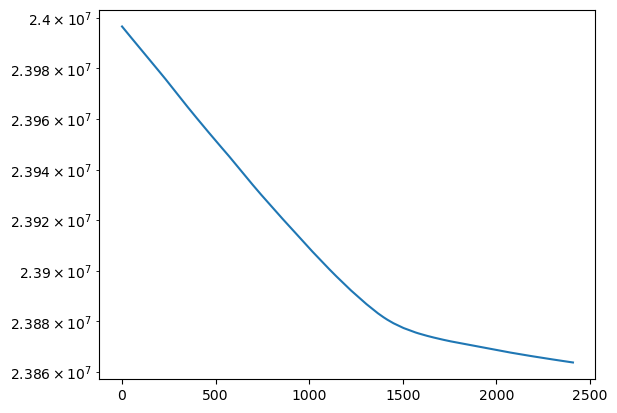

In [12]:
plt.plot(posterior_mut.samples['losses'])
plt.yscale("log")

### Looking at Presence of Mutations in Different Variants

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
im = ax.imshow(variant_frequencies_mut.mutation_presence, cmap="PuBu")
ax.set_yticks(np.arange(len(variant_frequencies_mut.var_names)), 
              labels=variant_frequencies_mut.var_names)
ax.set_xticks(np.arange(len(variant_frequencies_mut.mut_names)), 
              labels=variant_frequencies_mut.mut_names)
plt.setp(ax.get_xticklabels(),
         rotation = 90,
         ha = "right",
         rotation_mode = "anchor")
ax.set_title("Mutation Presence in Variants", 
             size=50)
fig.tight_layout()
plt.savefig("mutation_presence_heatmap.png",format='png',dpi=150)

# Assigning individual fitnesses to each mutation

In [ ]:
# Grabbing fitness for each mutation, in sorted order
def mutations(samples, data):
    rows_for_tsv = []
    delta = jnp.median(samples["raw_delta"], axis=0)
    idx = (-delta).argsort()[:len(delta)]
    for i in idx:
        array = delta[i]
        rows_for_tsv.append({'mutation':data.mut_names[i], 'fitness_effect':array})
    return rows_for_tsv
table = mutations(samples_mut, variant_frequencies_mut)
mutations_table = pd.DataFrame(table)

In [ ]:
# creating summary table with variant name, variant ga, mutation, mutation fitness
final_table = pd.merge(mut_ga, raw_muts, on="variant")
final_table = pd.merge(final_table, mutations_table, on="mutation")
final_table = final_table.drop(final_table.columns[0], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
final_table = final_table.drop(final_table.columns[2], axis=1)
# renaming the table
mutations_summary = final_table

In [ ]:
# viewing table of mutation fitnesses
mutations_summary

# Assigning innovation GA to variants

In [ ]:
# Getting data
raw_seq_innov = pd.read_csv("../count-data/pango_location-variant-sequence-counts.tsv", sep="\t")
# raw_variant_parents is missing a row for BA.2, so append one
raw_variant_parents = pd.concat((pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t"),
                                pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)
variant_frequencies_innov = ef.InnovationSequenceCounts(raw_seq_innov, raw_variant_parents, pivot="BA.2")

In [ ]:
# Defining model
mlr = ef.InnovationMLR(tau=4.2)
# Defining inference method
inference_method = ef.InferMAP(iters=50_000, lr=4e-3)
# Fitting model
posterior_innov = inference_method.fit(mlr, variant_frequencies_innov)
samples_innov = posterior_innov.samples

In [ ]:
innovation_ga = pd.DataFrame(
    ef.posterior.get_growth_advantage(samples_innov, posterior_innov.data, ps=[0.8], name="USA", rel_to="BA.2")
)

In [ ]:
#viewing innovation ga df
innovation_ga

# Comparing Innovation and Mutational Growth Advantages

In [ ]:
# resolving weird formatting issues btwn csv and loading pandas df??
mut_ga.to_csv('mut_ga.tsv', sep="\t")
innovation_ga.to_csv('innov_ga.tsv', sep="\t")

In [ ]:
# loading in datasets
parent_variant_relationships = pd.read_csv("../count-data/pango_variant-relationships.tsv", sep="\t").set_index("variant")
mut_ga = pd.read_csv("mut_ga.tsv", sep="\t")
innovation_ga = pd.read_csv("innov_ga.tsv", sep="\t")

In [ ]:
# Prep to merge
def clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships):
    innovation_ga = (innovation_ga
                     .rename(columns={"median_ga": "innov-ga"})
                     [["variant", "innov-ga"]])

    mut_ga = (mut_ga
              .rename(columns={"median_ga": "mut-ga"})
              [["variant", "mut-ga"]])

    ga_df = innovation_ga.merge(mut_ga, how="right").set_index("variant")
    ga_df["mut-ga"] = ga_df["mut-ga"] / ga_df.loc["BA.2.1"]["mut-ga"] # Scale GA by BA.2.1

    # Add parents
    def _get_parent(row):
        variant = row.name
        if variant in parent_variant_relationships.index:
            return parent_variant_relationships.loc[variant]
        return "NAN"

    ga_df["parent"] = ga_df.apply(_get_parent, axis=1)
    return ga_df

In [ ]:
ga_df = clean_and_merge(innovation_ga, mut_ga, parent_variant_relationships)

In [ ]:
# Look for parent for mut-parent-ga
def add_deltas(row, prefix):
    # Give up if parent not found
    if row.parent not in ga_df.index:
        return pd.Series([np.nan, np.nan],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    # Get child growth advantage
    parent_row = ga_df.loc[row.parent]
    
    # Return parent ga and ratio
    return pd.Series([parent_row[prefix + "-ga"],  row[prefix + "-ga"] / parent_row[prefix + "-ga"]],
                         index=[prefix + "-parent-ga", prefix + "-pc-ratio"])
    
ga_df[["mut-parent-ga", "mut-pc-ratio"]] = ga_df.apply(add_deltas, prefix="mut", axis=1)
ga_df[["innov-parent-ga", "innov-pc-ratio"]] = ga_df.apply(add_deltas, prefix="innov", axis=1)

In [ ]:
def is_outlier_IQR(data, col, scale=1.5):
    """
    Find wheter outliers in column col from dataframe data
    Uses IQR rule based on normal approximation.
    """

    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    lower_bound = Q1 - scale * IQR
    upper_bound = Q3 + scale * IQR
    return (data[col] < lower_bound) | (data[col] > upper_bound)

    
ga_df["innov-mut-ratio"] = ga_df["innov-ga"] / ga_df["mut-ga"]
ga_df["log-innov-mut-ratio"] = np.log(ga_df["innov-ga"] / ga_df["mut-ga"])
ga_df["outlier"] = is_outlier_IQR(ga_df, "log-innov-mut-ratio") # log-innov-mut-ratio ~ Normal()

In [ ]:
# viewing ga_df
ga_df

## Plotting mutational ga vs. innovation ga

Each datapoint is a variant. Red datapoints are variants in which the rato between innovation/mutational ga is considered an outlier. Therefore, red variants might indicate epistasis where blue datapoint variants would indicate no epistasis. 

In [ ]:
# Coloring by outlier
plt.scatter(ga_df["innov-ga"], ga_df["mut-ga"], 
            color=["pink" if value else "lightblue" for value in ga_df.outlier], 
            ec="k")
plt.plot([0.5, 2.5], [0.5, 2.5], color="k", linestyle="--")
plt.xlabel("Innovation GA")
plt.ylabel("Mutation GA")

# Looking at Outliers

In [ ]:
# Defining outliers
outliers = ga_df[ga_df.outlier & (ga_df["mut-pc-ratio"] < 0.5)]

In [ ]:
# Looking at outliers in bottom right with low ga
outliers

# Verifying Outlier Mutational GA Assignments

Given that:

    relative_fitness_variant = sum(mutational_fitness for mutation in variant)
    mutational_ga_variant = exp(relative_fitness_variant * generation_time)
    generation_time is fixed at 4.2

The calculated_ga variable for each variant is assigned using the equation above. 

In [ ]:
# compiling outlier summary table with indv fitnesses and mutational ga
outlier_variants = ga_df[ga_df["outlier"]].index
# just look at the outliers if there are any
# take the entire dataset if no outliers
if len(outlier_variants) < 1:
    outlier_variants = ga_df.index

# group by variants
grouped = mutations_summary.groupby('variant')
# final df
rows_for_tsv = []
for name, group in grouped:
    if name in outlier_variants:
        variant_dict = {}
        mutations = group['mutation']
        variant_dict['variant'] = name
        mut_ga = group['median_ga'].iloc[0]
        variant_dict['mut_ga'] = mut_ga
        cum_sum = 0
        for m in mutations:
            # grabbing the fitness effect  of each mutation
            fitness_effect = group.loc[group['mutation'] == m, 'fitness_effect'].iloc[0]
            variant_dict[m] = fitness_effect
            # summing up all mutation fitnesses
            cum_sum += fitness_effect
        # multiply by generation time and raise e to this number
        calculated_ga = math.exp(cum_sum * 4.2)
        variant_dict['calculated_ga'] = calculated_ga
        variant_dict['match'] = (mut_ga == calculated_ga)
        rows_for_tsv.append(variant_dict)
resulting_table = pd.DataFrame(rows_for_tsv)      

In [ ]:
#aesthetic changes to the summary df

# moving mut_ga to end 
cols_at_end = ['calculated_ga', 'mut_ga', 'match']
resulting_table = resulting_table[[c for c in resulting_table if c not in cols_at_end] 
        + [c for c in cols_at_end if c in resulting_table]]
# concatenating innovation ga column info 
if len(ga_df[ga_df["outlier"]].index) < 1:
    # take entire dataset if no outliers exist
    trimmed = ga_df.drop(columns=['mut-ga','parent','mut-parent-ga','mut-pc-ratio','innov-parent-ga','innov-pc-ratio','innov-mut-ratio','log-innov-mut-ratio','outlier'])
else:
    # just look at the outliers if there are any
    trimmed = ga_df[ga_df["outlier"]].drop(columns=['mut-ga','parent','mut-parent-ga','mut-pc-ratio','innov-parent-ga','innov-pc-ratio','innov-mut-ratio','log-innov-mut-ratio','outlier'])

merged = pd.merge(resulting_table, trimmed, on="variant", how="left")
resulting_table = merged

In [ ]:
# viewing mutational fitnesses for outliers
resulting_table

In [ ]:
# saving summary table to csv
resulting_table.to_csv('reformatted_table.tsv', sep='\t')